In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [112]:
train= pd.read_csv(r'D:\B Drive\Data Science\Practice Data\Titanic\train.csv')
test= pd.read_csv(r'D:\B Drive\Data Science\Practice Data\Titanic\test.csv')
IDtest=test["PassengerId"]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
def detect_outliers(df,n,features):
    outlier_indices= []
    for col in features:
        Q1= np.percentile(df[col],25)
        Q3= np.percentile(df[col],75)
        
        IQR= Q3-Q1
        
        outlier_step = 1.5* IQR
        
        outlier_list_col= df[(df[col]<Q1-outlier_step)| (df[col]> Q3+outlier_step)].index
        
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices= Counter(outlier_indices)
    
    multiple_outlier= list(k for k,v in outlier_indices.items() if v>2)
    
    return multiple_outlier

Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])


In [7]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [8]:
train= train.drop(Outliers_to_drop, axis=0).reset_index(drop= True)

In [9]:
missing_counts = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()*100/train.shape[0]).sort_values(ascending = False)

missing_df = pd.concat([missing_counts, percent], axis = 1, keys = ['Counts', '%'])
print('Missing values: ')
display(missing_df.head().style.background_gradient(cmap = 'Reds', axis = 0))

Missing values: 


,Counts,%
Cabin,680,77.185017
Age,170,19.296254
Embarked,2,0.227015
Fare,0,0.000000
Ticket,0,0.000000


In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>,
        <AxesSubplot:title={'center':'Pclass'}>, <AxesSubplot:>]],
      dtype=object)

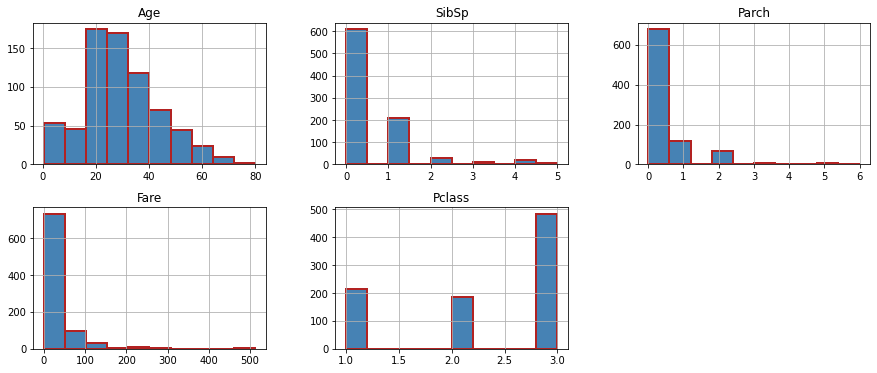

In [11]:
coln = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
train[coln].hist(figsize = (15, 6), color = 'steelblue', edgecolor = 'firebrick', linewidth =2, layout = (2,3))

# 1. Feature Analysis


1.1 NUMERICAL VALUES

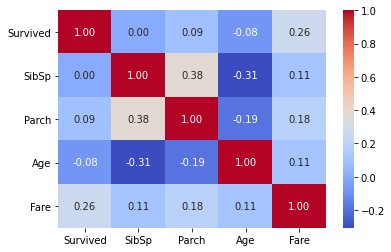

In [12]:
a= sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot = True, fmt = ".2f", cmap = "coolwarm")

1.11 SibSp

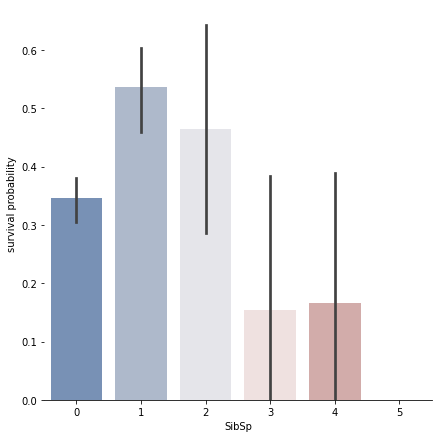

In [13]:
g = sns.catplot(x="SibSp",y="Survived",data=train,kind="bar", height = 6, palette="vlag" )
g.despine(left=True)
g = g.set_ylabels("survival probability")

Single passengers (0 SibSP) or passengers having 1-2 relatives on board (SibSP 1 or 2) have more chance to survive while it seems that passengers having a lot of siblings/spouses have less chance to survive.

1.12 Parch

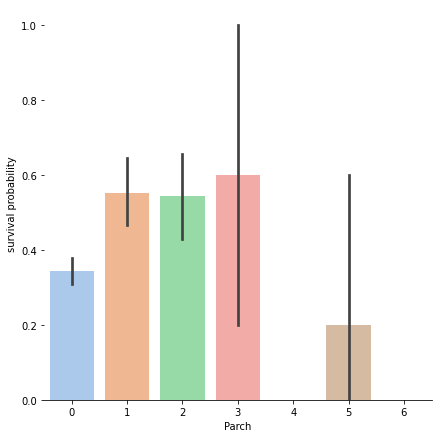

In [14]:
# Explore Parch feature vs Survived
g  = sns.catplot(x="Parch",y="Survived",data=train,kind="bar", height = 6 , 
palette = "pastel")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families (Parch 1,2) have more chance to survive when compared to single (parch 0), medium(parch 3,4) and large family(parch 5)

NOTE: There is an important standard deviation in the survival of passengers with 3 parents/children

In [15]:
alone = train[(train['SibSp']==0) & (train['Parch']==0)]
not_alone= train[(train['SibSp'] !=0) | (train['Parch']!=0)]

Text(0, 0.5, 'No. of Passengers')

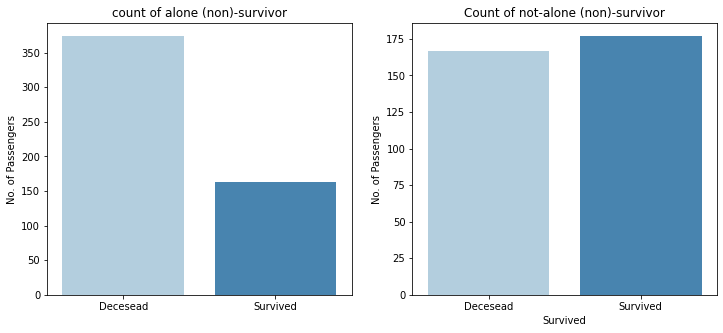

In [16]:
fig, (ax1,ax2)= plt.subplots(1,2, figsize= (12,5))

sns.countplot(x='Survived', data = alone, palette = 'Blues', ax= ax1)
ax1.set_title('count of alone (non)-survivor')
ax1.set_xlabel('')
ax1.set_xticklabels(['Decesead', 'Survived'])
ax1.set_ylabel('No. of Passengers')

sns.countplot(x='Survived', data = not_alone, palette = 'Blues', ax= ax2)
ax2.set_title('Count of not-alone (non)-survivor')
ax1.set_xlabel('')
ax2.set_xticklabels(['Decesead', 'Survived'])
ax2.set_ylabel('No. of Passengers')

Hence we can say that having 1 to 2 relatives on board can actually increase your chances of survival.

 1.13 Age


In [17]:
men=  train[train['Sex']== 'male']
women= train[train['Sex']== 'female']

Text(0.5, 1.0, 'Age Distribution - women')

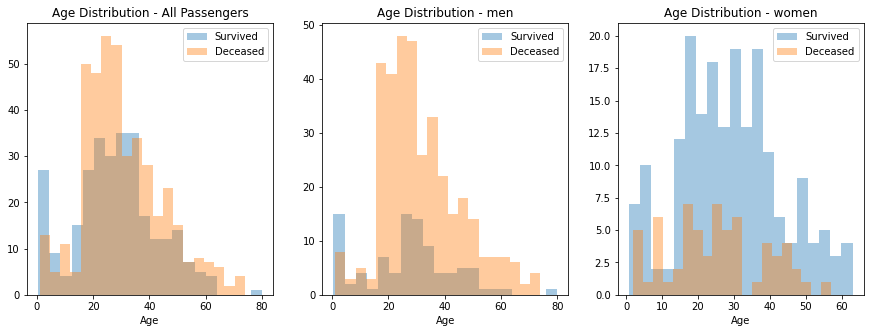

In [18]:
fig, (ax1, ax2,ax3)= plt.subplots(1,3, figsize=(15,5))

sns.distplot(train[train['Survived']==1]['Age'].dropna(), bins= 20, label= 'Survived', kde= False, ax=  ax1)
sns.distplot(train[train['Survived']==0]['Age'].dropna(), bins= 20, label= 'Deceased', kde= False, ax=  ax1)
ax1.legend()
ax1.set_title('Age Distribution - All Passengers')

sns.distplot(men[men['Survived']==1]['Age'].dropna(), bins= 20, label= 'Survived', kde= False, ax=  ax2)
sns.distplot(men[men['Survived']==0]['Age'].dropna(), bins= 20, label= 'Deceased', kde= False, ax=  ax2)
ax2.legend()
ax2.set_title('Age Distribution - men')

sns.distplot(women[women['Survived']==1]['Age'].dropna(), bins= 20, label= 'Survived', kde= False, ax=  ax3)
sns.distplot(women[women['Survived']==0]['Age'].dropna(), bins= 20, label= 'Deceased', kde= False, ax=  ax3)
ax3.legend()
ax3.set_title('Age Distribution - women')

It is evident that different age groups had very different survival rates. For instance, both genders display a higher probability of survival between the ages of 15 and 45. Also, the spike at young ages (0-4) shows that infants and young children have higher odds of survival.We also see that passengers between 60-80 have less survived.

So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

It seems that very young passengers have more chance to survive.

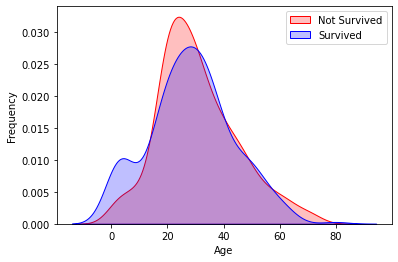

In [19]:
a= sns.kdeplot(train['Age'][(train["Survived"]==0) & (train["Survived"].notnull())], color= "Red", shade= True)

a= sns.kdeplot(train['Age'][(train["Survived"]==1) & (train["Survived"].notnull())],ax=a, color= "Blue", shade= True)
a.set_xlabel("Age")
a.set_ylabel("Frequency")
a= a.legend(["Not Survived","Survived"])


When we superimpose the two densities , we cleary see a peak correponsing (between 0 and 5) to babies and very young childrens.

In [20]:
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [21]:
dataset.shape

(1299, 12)

In [22]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [23]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [24]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [25]:
dataset['Fare']= dataset['Fare'].fillna(dataset['Fare'].median())

In [26]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1007
Embarked          2
dtype: int64

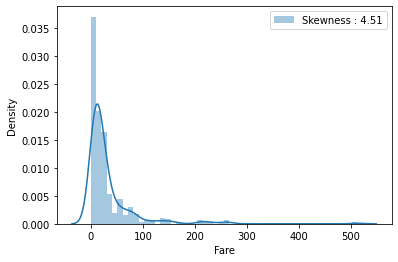

In [27]:
a= sns.distplot(dataset["Fare"],label="Skewness : %.2f"%(dataset["Fare"].skew()))
a= a.legend()

As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce this skew.

In [28]:
dataset['Fare']= dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

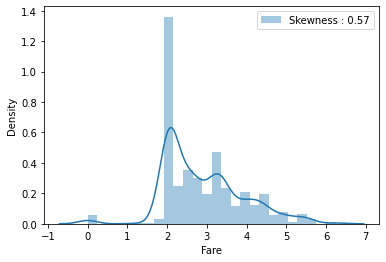

In [29]:
a= sns.distplot(dataset["Fare"],label="Skewness : %.2f"%(dataset["Fare"].skew()))
a= a.legend()

Skewness is clearly reduced after the log transformation

One would assume that fare is closely related to class. Let's plot a boxplot for the distribution of Fare values across classes and a histogram for survival:

# 1.2 CATEGORICAL VALUES

1.21 Gender

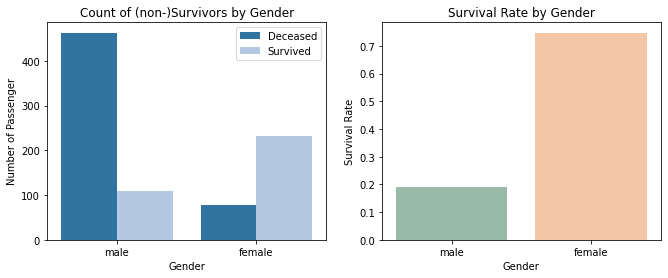

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 4))

sns.countplot(x = 'Sex', hue = 'Survived', data = train,  palette = 'tab20', ax = ax1) 
ax1.set_title('Count of (non-)Survivors by Gender')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Number of Passenger')
ax1.legend(labels = ['Deceased', 'Survived'])

sns.barplot(x = 'Sex', y = 'Survived', data = train,  palette = ['#94BFA7', '#FFC49B'], ci = None, ax = ax2)
ax2.set_title('Survival Rate by Gender')
ax2.set_xlabel('Gender')
ax2.set_ylabel('Survival Rate');

In [31]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


There were more men than women on board. However, more women survived the shipwreck (the survival rate is almost 75% for women compared to only 20% for men!).Hence we can say that, "women and children first" protocol was implemented for boarding lifeboats. So Gender might play an important role in the prediction of the survival.

In [32]:
train['Pclass'].value_counts()

3    484
1    213
2    184
Name: Pclass, dtype: int64

Text(0, 0.5, 'Survived by rate')

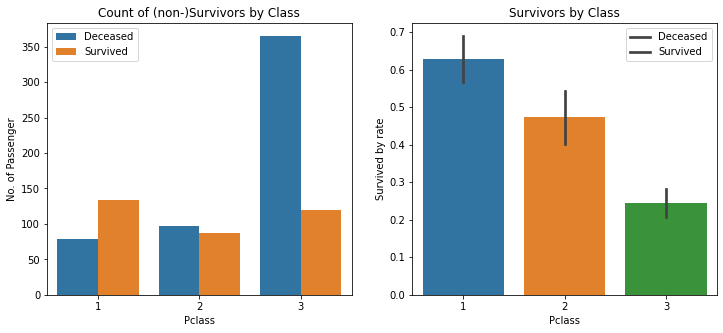

In [33]:
fig, (ax1,ax2)= plt.subplots(1,2, figsize= (12,5))

sns.countplot(x='Pclass', hue= 'Survived',data= train, ax=ax1)
ax1.set_title('Count of (non-)Survivors by Class')
ax1.legend(('Deceased', 'Survived'))
ax1.set_ylabel('No. of Passenger')


sns.barplot(x='Pclass', y= 'Survived',data= train, ax=ax2)
ax2.set_title('Survivors by Class')
ax2.legend(('Deceased', 'Survived'))
ax2.set_ylabel('Survived by rate')

More than 50% of passengers boarded in the 3rd class. Nevertheless, survival favours the wealthy as shown in the right figure (the survival rate increases as we move from 3rd to 1st class).

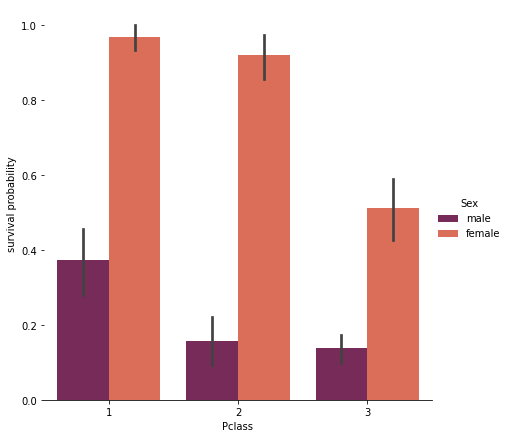

In [34]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   height=6, kind="bar", palette="rocket")
g.despine(left=True)
g = g.set_ylabels("survival probability")

This trend is conserved when we look at both male and female passengers.

# 1.23 PORT OF EMBARKATION

In [35]:
dataset["Embarked"].isnull().sum()

2

In [36]:
dataset["Embarked"].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [37]:
dataset["Embarked"]= dataset["Embarked"].fillna('S')

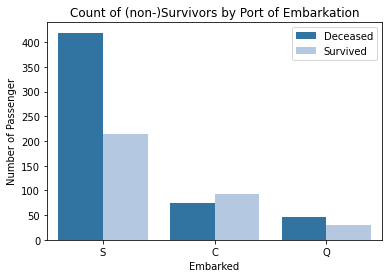

In [38]:
sns.countplot(x = 'Embarked', hue = 'Survived', data = train,  palette = 'tab20') 
plt.ylabel('Number of Passenger')
plt.title('Count of (non-)Survivors by Port of Embarkation')
plt.legend(['Deceased', 'Survived'])

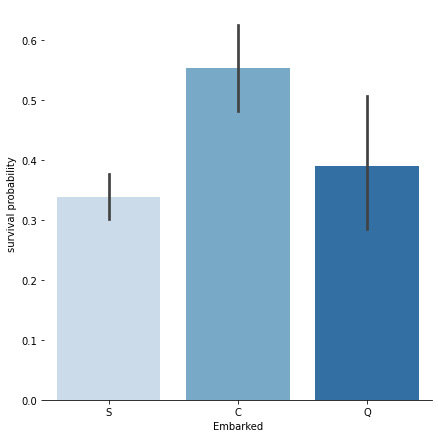

In [39]:
g = sns.catplot(x="Embarked", y="Survived",data=train,height=6, kind="bar", palette="Blues")
g.despine(left=True)
g = g.set_ylabels("survival probability")

From the above plot we can see that passengers coming from Cherbourg (C) have more chance to survive.

Maybe the proportion of first class passengers is higher for those who came from Cherbourg (C) than Queenstown (Q), Southampton (S).

Let's see the Pclass distribution vs Embarked

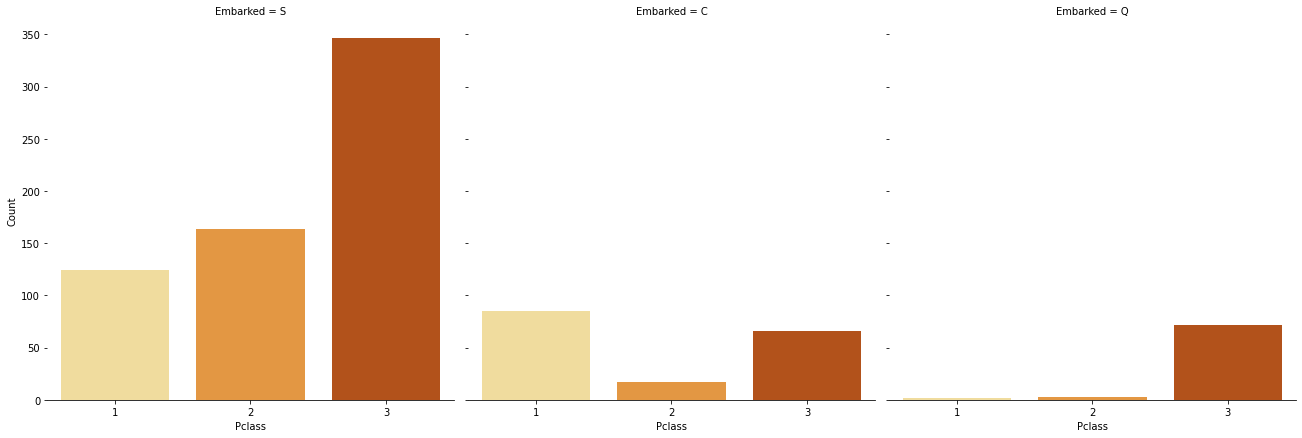

In [40]:
# Explore Pclass vs Embarked 
g = sns.catplot("Pclass", col="Embarked",  data=train,
                   height=6, kind="count", palette="YlOrBr")
g.despine(left=True)
g = g.set_ylabels("Count")

Indeed, the third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

Maybe we can say that first class passengers were prioritised during the evacuation due to their influence.

# 2. Filling missing Values

2.1 AGE

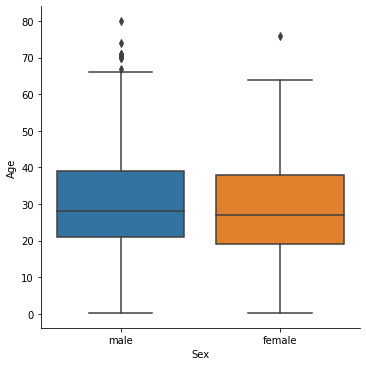

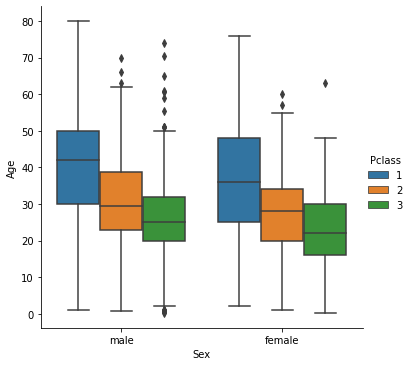

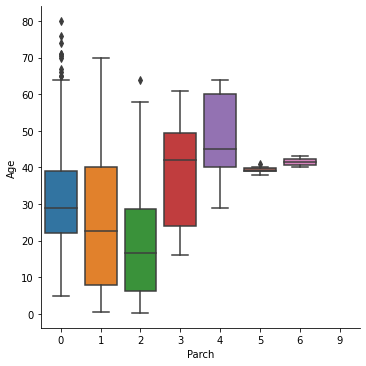

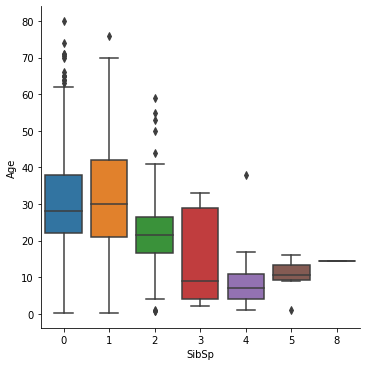

In [41]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.catplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")

Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

However, 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

In [42]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

In [43]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

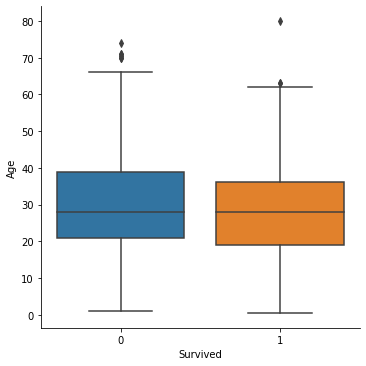

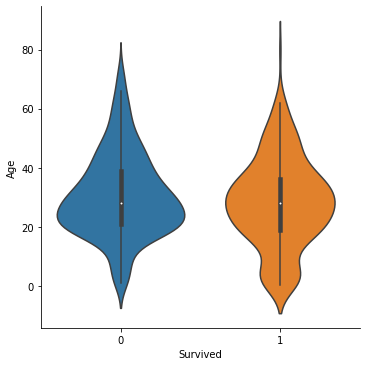

In [44]:
g = sns.catplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.catplot(x="Survived", y = "Age",data = train, kind="violin")

No difference between median value of age in survived and not survived subpopulation.

But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.

2.2 Fare

In [45]:
dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# 3. FEATURE ENGINEERING

3.1 NAME/TITLE

In [46]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The Name feature contains information on passenger's title.

Since some passenger with distingused title may be preferred during the evacuation, it is interesting to add them to the model.

In [47]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

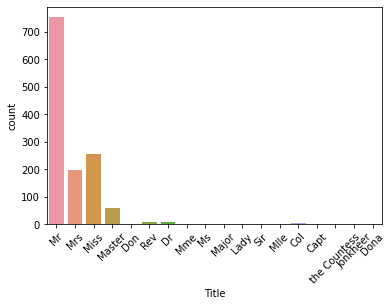

In [48]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

There is 17 titles in the dataset, most of them are very rare and we can group them in 4 categories.

In [49]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

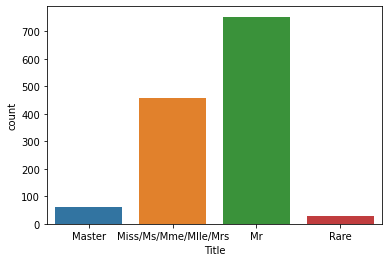

In [52]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

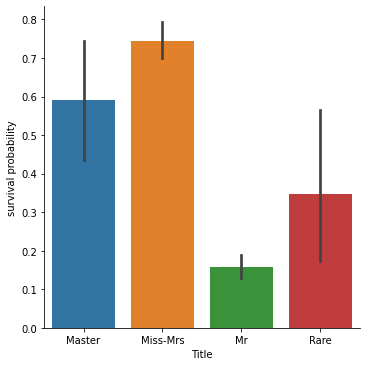

In [53]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

We have already seen that women (Mrs or Miss) had higher odds of survival. Now here, notice that Masters and people with a Rare Title have indeed a higher chance of survival compared to 'common' men (Mr).

In [55]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

3.2 FAMILY SIZE

We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation. So, i choosed to create a "Fize" (family size) feature which is the sum of SibSp , Parch and 1 (including the passenger).

In [56]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

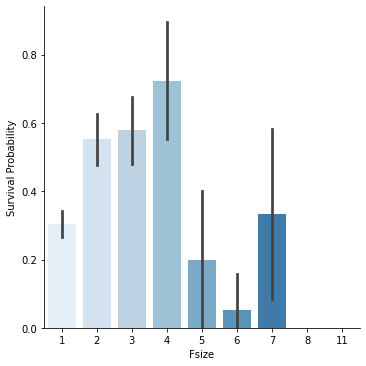

In [57]:
g = sns.catplot(x="Fsize",y="Survived",data = dataset, kind='bar', palette='Blues')
g = g.set_ylabels("Survival Probability")

The family size seems to play an important role, survival probability is worst for large families.

We create 4 categories of family size.

In [58]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

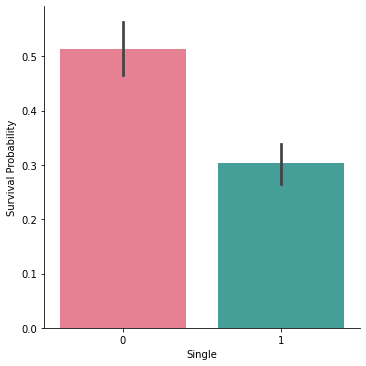

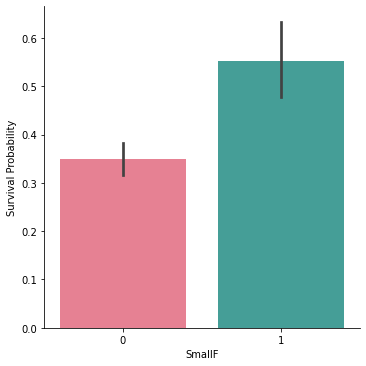

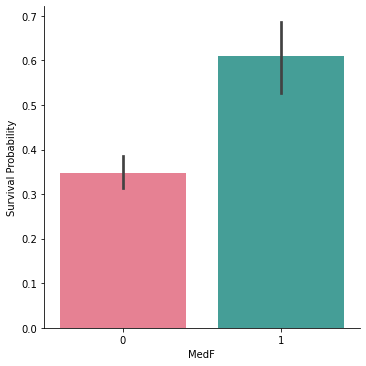

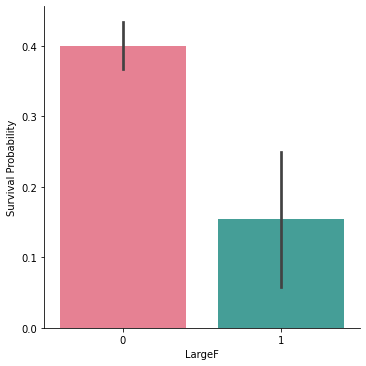

In [59]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar", palette='husl')
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar",palette='husl')
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar", palette='husl')
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar", palette='husl')
g = g.set_ylabels("Survival Probability")

Catplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families.

In [60]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [61]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


In [63]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [64]:
dataset["Cabin"].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [65]:
dataset["Cabin"].isnull().sum()

1007

The Cabin feature column contains 292 values and 1007 missing values.

In [66]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [67]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

The first letter of the cabin indicates the Desk, i choosed to keep this information only, since it indicates the probable location of the passenger in the Titanic.

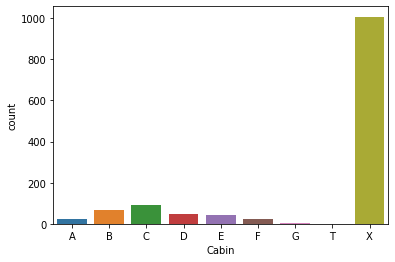

In [68]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

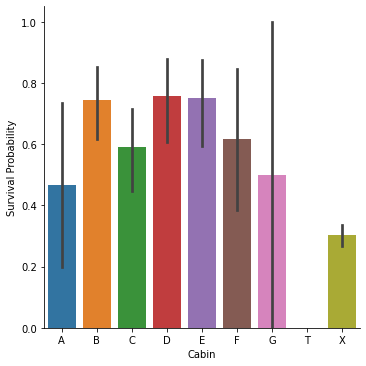

In [69]:
g = sns.catplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

Because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in the different desks.

But we can see that passengers with a cabin have generally more chance to survive than passengers without (X).

It is particularly true for cabin B, C, D, E and F.

In [70]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

3.4 TICKET

In [71]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It could mean that tickets sharing the same prefixes could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship.

Tickets with same prefixes may have a similar class and survival.

So let's replace the Ticket feature column by the ticket prefixe. Which may be more informative.

In [72]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
        #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket

dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [73]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [74]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [75]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [76]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


4. MODELING

In [93]:
## Separate train dataset and test dataset
train_len= len(train)
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

In [94]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

4.1 Simple Modelling

Cross Validate Model

Let's compare popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

SVC

Decision Tree

AdaBoost

Random Forest

Extra Trees

Gradient Boosting

Multiple layer perceprton (neural network)

KNN

Logistic regression

Linear Discriminant Analysis

In [95]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

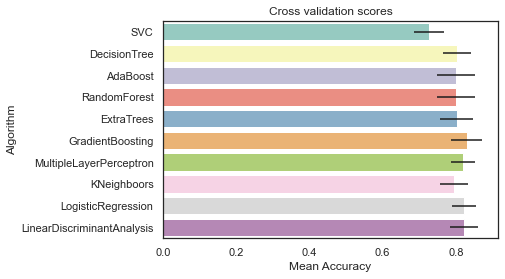

In [96]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

So we choose SVC, AdaBoost, RandomForest , ExtraTrees and the GradientBoosting classifiers for the ensemble modeling.

4.12 Hyperparameter tunning for best models


grid search optimization for AdaBoost, ExtraTrees , RandomForest, GradientBoosting and SVC classifiers.

In [97]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [99]:
gsadaDTC.best_score_

0.8241317671092953

In [101]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8308861082737489

In [102]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.833158835546476

In [103]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8308733401430031

In [104]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

4.13 Plot learning curves


Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

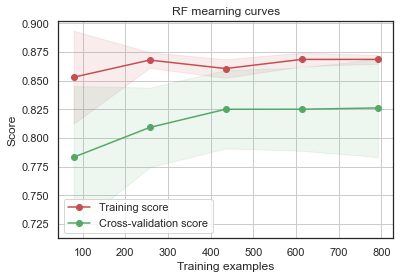

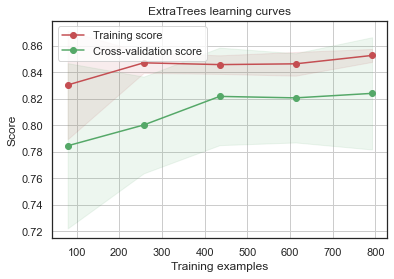

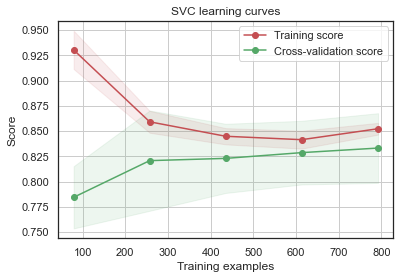

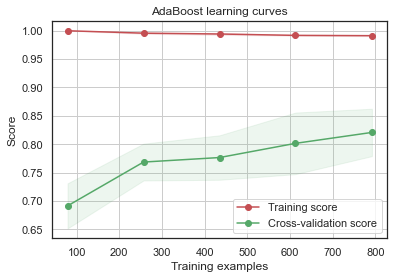

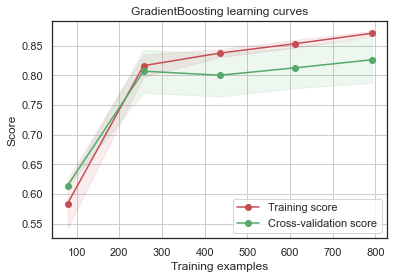

In [105]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

GradientBoosting and Adaboost classifiers tend to overfit the training set. According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples.


SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

4.14 Feature importance of tree based classifiers


In order to see the most informative features for the prediction of passengers survival, i displayed the feature importance for the 4 tree based classifiers.

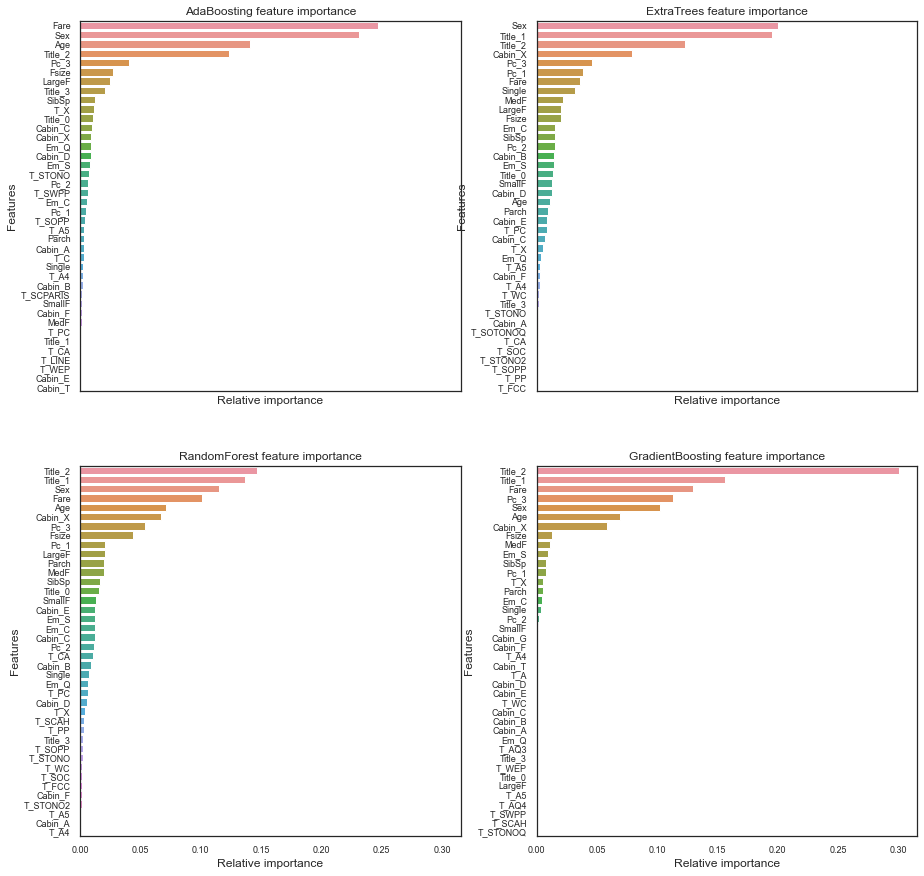

In [106]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

plot the feature importance for the 4 tree based classifiers (Adaboost, ExtraTrees, RandomForest and GradientBoosting).


We note that the four classifiers have different top features according to the relative importance. It means that their predictions are not based on the same features. Nevertheless, they share some common important features for the classification , for example 'Fare', 'Title_2', 'Age' and 'Sex'.


Title_2 which indicates the Mrs/Mlle/Mme/Miss/Ms category is highly correlated with Sex.


We can say that:


Pc_1, Pc_2, Pc_3 and Fare refer to the general social standing of passengers.


Sex and Title_2 (Mrs/Mlle/Mme/Miss/Ms) and Title_3 (Mr) refer to the gender.


Age and Title_1 (Master) refer to the age of passengers.


Fsize, LargeF, MedF, Single refer to the size of the passenger family.



According to the feature importance of this 4 classifiers, the prediction of the survival seems to be more associated with the Age, the Sex, the family size and the social standing of the passengers more than the location in the boat.

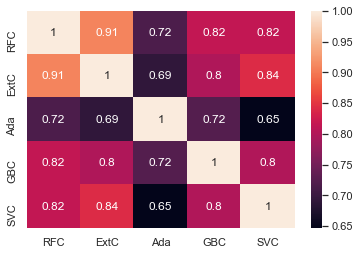

In [107]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

The prediction seems to be quite similar for the 5 classifiers except when Adaboost is compared to the others classifiers.


The 5 classifiers give more or less the same prediction but there is some differences. Theses differences between the 5 classifier predictions are sufficient to consider an ensembling vote.


4.2 Ensemble modeling

4.21 Combining models

A voting classifier to combine the predictions coming from the 5 classifiers.


Pass the argument "soft" to the voting parameter to take into account the probability of each vote.

In [108]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

4.3 Prediction


4.31 Predict and Submit results


In [ ]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)